# Minimise file sizes read to memory;

1. Read only points from `.POST` files which are internally H5.
2. query the following points:

In [1]:
import os
import h5py
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# Define the data folder - must include .h5 cas and dat files.
DataFolder = r'/Users/laurenilano/Downloads/THESIS/DATS/'#M1-transient-1100time-step-1-01150.dat.h5'

from cmcrameri import cm

In [2]:
# DOMAIN PARAMETERS - only for plotting purposes.
Ypixels = 1080
XMIN    = -0.25
XMAX    = 0.25
YMIN    = -0.02
YMAX    = 0.08
AspectRatio     = (XMAX-XMIN)/(YMAX-YMIN)
Xpositions      = np.linspace(XMIN,XMAX,int(Ypixels*AspectRatio))
Ypositions      = np.linspace(YMAX,YMIN,Ypixels)
[xgrid,ygrid]   = np.meshgrid(Xpositions,Ypositions)
Clim = [300, 310]

In [3]:
# Read Fluent mesh from case file
casefiles = [f for f in os.listdir(DataFolder) if f.endswith('.cas.h5')]


def get_cells_from_cas(casefile):
    """Obtains cell centroid coordinates from a casefile. 
    Takes vertex indices, maps vertices to faces, and maps faces to cells. 
    Cell centroids are obtained and one zval is ascribed to one cell centroid.
    """
    fname = os.path.join(DataFolder, casefile)

    with h5py.File(fname, 'r') as f:
        VertexList = f['/meshes/1/nodes/coords/1'][:].T  # Shape should be (2, N)
        FaceIdToVertexId = f['/meshes/1/faces/nodes/1/nodes'][:]  # Shape (M,)
        FaceIdToCellId = np.array(f['/meshes/1/faces/c0/1'][:])  # Shape (M/2,)

    # take a cell==face, look at the edges, and then the vertices that make up the edge, then access
    # each coordinate 
    # 1 cell has 4 edges, each with 2 vertices, so overall 1 cell has 8 rows; 
    
    # Reshape VertexList based on FaceIdToVertexId (adjusting to 0-based index)
    vertex_indices = FaceIdToVertexId - 1  # Convert to 0-based index
    vertex_coords_x = VertexList[0, vertex_indices]
    vertex_coords_y = VertexList[1, vertex_indices]

    # Reshape into pairs of vertices for each face
    vertex_coords_x = vertex_coords_x.reshape((2, -1), order='F')
    vertex_coords_y = vertex_coords_y.reshape((2, -1), order='F')

    # Compute face centers
    # the face center is the average of the x and y vertex coords of the current cell, acc to cell ID.
    face_centers_x = np.mean(vertex_coords_x, axis=0)
    face_centers_y = np.mean(vertex_coords_y, axis=0)

    # Initialize cell centroids
    num_cells = np.max(FaceIdToCellId)
    CellX = np.zeros(num_cells)
    CellY = np.zeros(num_cells)
    counts = np.zeros(num_cells, dtype=int)

    # Aggregate face centers to compute cell centroids
    for i in range(len(FaceIdToCellId)):
        cell_id = FaceIdToCellId[i] - 1  # Adjust to 0-based index
        CellX[cell_id] += face_centers_x[i]
        CellY[cell_id] += face_centers_y[i]
        counts[cell_id] += 1

    # Compute centroids by dividing by the counts
    CellX /= counts
    CellY /= counts

    return CellX, CellY

In [4]:
casefile = casefiles[0]
CellX, CellY = get_cells_from_cas(casefile)

def get_xyz(CellX, CellY, datafile):
    """Maps cell centroid coordinates to zvalues from a datafile. 
    """
    fname = os.path.join(DataFolder, datafile)
    
    with h5py.File(fname, 'r') as f:
        T = f['/results/1/phase-1/cells/SV_T/1'][:]
        return T
    
    
def get_interpolated_contour(CellX, CellY, datafile):
    """Map cell centroid coordinates to zvalues from a datafile.
    Interpolates the cell centers + associated z value to a uniform grid
    for plotting purposes.
    """
    fname = os.path.join(DataFolder, datafile)
    
    Z = get_xyz(CellX, CellY, fname)
    
    # DOMAIN PARAMETERS - only for plotting purposes.
    Ypixels = 1080
    XMIN    = -0.25
    XMAX    = 0.25
    YMIN    = -0.02
    YMAX    = 0.08
    AspectRatio     = (XMAX-XMIN)/(YMAX-YMIN)
    Xpositions      = np.linspace(XMIN,XMAX,int(Ypixels*AspectRatio))
    Ypositions      = np.linspace(YMAX,YMIN,Ypixels)
    [xgrid,ygrid]   = np.meshgrid(Xpositions,Ypositions)
    Clim = [300, 310]

    if len(CellX) == len(CellY) == len(Z):
        from scipy.interpolate import griddata
        SI = griddata((CellX, CellY), Z, (xgrid, ygrid), method='linear', fill_value=np.nan)
        return SI
    else:
        raise ValueError("Lengths of CellX, CellY, and T do not match!")

def query_point(CellX, CellY, z, query_x, query_y):
    """Given a set of cell coords CellX, CellY, and a requested coordinate index,
    obtain the corresponding z value from the entire z array. 
    
    """
    tolerance = 1e-4
    rtol=1e-7
    new_index = np.where(np.isclose(CellX, query_x, atol=tolerance, rtol=rtol) & np.isclose(CellY, query_y, atol=tolerance, rtol=rtol))
    
    return new_index, z[new_index]

In [6]:
# Read temperature data
datafiles = [f for f in os.listdir(DataFolder) if f.endswith('dat.h5')]


SI = get_interpolated_contour(CellX, CellY, datafiles[0])

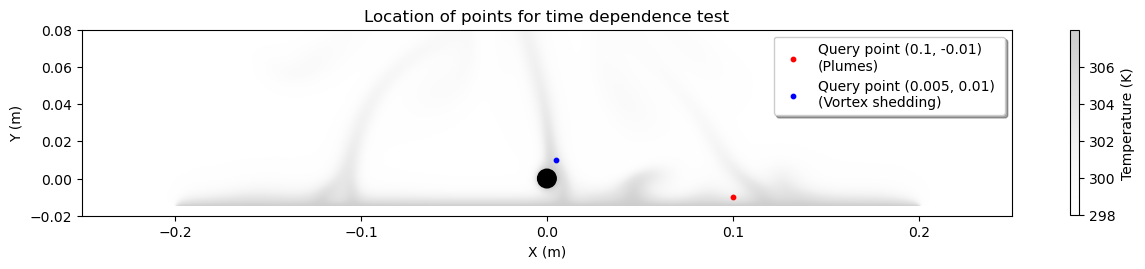

In [7]:
fig, ax = plt.subplots(figsize=(15,12))

#Clim = [np.min(T), np.max(T)]

# Create initial image
#ax.scatter(CellX, CellY, c='blue', label='Cell centroids')
p_ = ax.imshow(SI, extent=[XMIN, XMAX, YMIN, YMAX], cmap='Greys', alpha=0.2)

ax.set_ylim([YMIN, YMAX])
circle = plt.Circle((0, 0), 0.005, color='black', fill=True)
ax.add_patch(circle)

ax.scatter([0.1], [-0.01], s=10, c='red', label="Query point (0.1, -0.01) \n(Plumes)")
ax.scatter([0.005], [0.01], s=10, c='b', label="Query point (0.005, 0.01) \n(Vortex shedding)")
plt.colorbar(p_, ax=ax, label='Temperature (K)', shrink=0.2, )
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Location of points for time dependence test')
plt.legend(frameon=True, fancybox=True, shadow=True)

#plt.savefig('./points_For_mesh_time_Dep.pdf', dpi=300, bbox_inches='tight')

#plt.close()


In [16]:
fname = "/Users/laurenilano/Downloads/THESIS/POST_FILES/M4-0105.dat.post"

# From https://stackoverflow.com/questions/43371438/how-to-inspect-h5-file-in-python
def scan_hdf52(path, recursive=True, tab_step=2):
    def scan_node(g, tabs=0):
        elems = []
        for k, v in g.items():
            if isinstance(v, h5py.Dataset):
                elems.append(v.name)
            elif isinstance(v, h5py.Group) and recursive:
                elems.append((v.name, scan_node(v, tabs=tabs + tab_step)))
        return elems
    with h5py.File(path, 'r') as f:
        return scan_node(f)
    

# Likely one per boundary - none for the internal fluid yet.
scan_hdf52(fname) #, recursive=True

[('/results',
  [('/results/1.post',
    [('/results/1.post/mixture',
      [('/results/1.post/mixture/nodes',
        ['/results/1.post/mixture/nodes/fields',
         ('/results/1.post/mixture/nodes/Static Temperature',
          ['/results/1.post/mixture/nodes/Static Temperature/1',
           '/results/1.post/mixture/nodes/Static Temperature/2',
           '/results/1.post/mixture/nodes/Static Temperature/3',
           '/results/1.post/mixture/nodes/Static Temperature/4',
           '/results/1.post/mixture/nodes/Static Temperature/5',
           '/results/1.post/mixture/nodes/Static Temperature/6',
           '/results/1.post/mixture/nodes/Static Temperature/7',
           '/results/1.post/mixture/nodes/Static Temperature/8',
           '/results/1.post/mixture/nodes/Static Temperature/9']),
         ('/results/1.post/mixture/nodes/Wall Temperature',
          ['/results/1.post/mixture/nodes/Wall Temperature/1',
           '/results/1.post/mixture/nodes/Wall Temperature/2',
     

### For 1000 seconds, 0.05 timestep size, this equals 20000 iterations.